# SQL in Python - Connecting to and retrieving data from PostgreSQL

Previously, you have learned how to connect to a SQL database by using a SQL client such as DBeaver. Apart from connecting to databases, DBeaver also allows you to run SQL queries against the database, create new tables and populate them with data as well as retrieving the data.

Python also allows executing SQL queries and getting the result into a Python object, for example a Pandas data frame. Instead of exporting a .csv file from DBeaver you can directly get the data you need into Python and continue your work. In addition we can reduce the steps by connecting to the database from Python directly, eliminating the need for a separate SQL client.

After you have the data in Python in the required shape you can export the data into a .csv file. This file is for your own reference, please avoid sending .csv files around - database is the point of reference when it comes to data. 

Having a copy of a .csv file (or another format) can speed up your analysis work. Imagine that the query takes 25 minutes to run. If you made some mistakes in your Python code you might need to go back to the original dataset. Instead of having to rerun the SQL query and having to wait you can read in the .csv file you have previously saved on your hard disk into Python and continue with your analysis work. 

**In this notebook you will see 2 ways to connect to SQL-Databases and export the data to a CSV file**


## Creating a connection to a PostgreSQL database with Python

There are 2 python packages that are the "go-to" when it comes to connecting to SQL-Databases: `psycopg2` and `sqlalchemy` 

### Connecting via psycopg2

In [2]:
import pandas as pd
import psycopg2


In order to create a connection to our PostgreSQL database we need the following information:

- host = the address of the machine the database is hosted on
- port = the virtual gate number through which communication will be allowed
- database = the name of the database
- user = the name of the user
- password = the password of the user

Because we don't want that the database information is published on github we put it into a `.env` file which is added into the `.gitignore`. 
In these kind of files you can store information that is not supposed to be published.
With the `dotenv` package you can read the `.env` files and get the variables.
(We will share the file with you on Slack!)


In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

The function from the psycopg2 package to create a connection is called `connect()`.
`connect()` expects the parameters listed above as input in order to connect to the database.

In [4]:
# Create connection object conn

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

### Retrieving data from the database with psycopg2

Before we can use our connection to get data, we have to create a cursor. A cursor allows Python code to execute PostgreSQL commmands in a database session.
A cursor has to be created with the `cursor()` method of our connection object conn.

In [5]:
cur = conn.cursor()

Now we can run SQL-Queries with `cur.execute('QUERY')` and then run `cur.fetchall()` to get the data:

In [6]:
cur.execute('SELECT * FROM eda.king_county_house_sales LIMIT 10')
cur.fetchall()

[(datetime.date(2014, 10, 13), 221900.0, 7129300520, 1),
 (datetime.date(2014, 12, 9), 538000.0, 6414100192, 2),
 (datetime.date(2015, 2, 25), 180000.0, 5631500400, 3),
 (datetime.date(2014, 12, 9), 604000.0, 2487200875, 4),
 (datetime.date(2015, 2, 18), 510000.0, 1954400510, 5),
 (datetime.date(2014, 5, 12), 1230000.0, 7237550310, 6),
 (datetime.date(2014, 6, 27), 257500.0, 1321400060, 7),
 (datetime.date(2015, 1, 15), 291850.0, 2008000270, 8),
 (datetime.date(2015, 4, 15), 229500.0, 2414600126, 9),
 (datetime.date(2015, 3, 12), 323000.0, 3793500160, 10)]

With `conn.close()` you can close the connection again.

In [6]:
#close the connection
conn.close()

But we want to work with the data. The easiest way is to import the data into pandas dataframes. We can use `pd.read_sql_query` or `pd.read_sql_table` or for convenience `pd.read_sql`.

This function is a convenience wrapper around read_sql_table and read_sql_query (for backward compatibility). It will delegate to the specific function depending on the provided input. A SQL query will be routed to read_sql_query , while a database table name will be routed to read_sql_table . Note that the delegated function might have more specific notes about their functionality not listed here.

In [12]:
# Open connection again because we closed it
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

LOAD THE DATA AND COMBINE THE 2 TABLES INTO ONE

In [13]:

# Load the data from SQL into pandas DataFrames
query_details = "SELECT * FROM eda.king_county_house_details"
query_sales = "SELECT * FROM eda.king_county_house_sales"

df_details = pd.read_sql(query_details, conn)
df_sales = pd.read_sql(query_sales, conn)

# Perform the left join
result_df = pd.merge(df_details, df_sales, left_on='id', right_on='house_id', how='left')

# Select specific columns
result_df = result_df[['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']]

# Rename columns for clarity
result_df.rename(columns={'date': 'price_date', 'price': 'selling_price'}, inplace=True)

# Display the resulting DataFrame
result_df.head()

/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1906532434.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_details = pd.read_sql(query_details, conn)
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1906532434.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales = pd.read_sql(query_sales, conn)


,house_id,price_date,selling_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1000102,2014-09-16,280000.0,6.0,3.0,2400.0,9373.0,2.0,NaN,0.0,...,7,2400.0,0.0,1991,0.0,98002,47.3262,-122.214,2060.0,7316.0
1,1000102,2015-04-22,300000.0,6.0,3.0,2400.0,9373.0,2.0,NaN,0.0,...,7,2400.0,0.0,1991,0.0,98002,47.3262,-122.214,2060.0,7316.0
2,100100050,2014-11-12,275000.0,3.0,1.0,1320.0,11090.0,1.0,0.0,0.0,...,7,1320.0,0.0,1955,0.0,98155,47.7748,-122.304,1320.0,8319.0
3,1001200035,2015-03-06,272450.0,3.0,1.0,1350.0,7973.0,1.5,NaN,0.0,...,7,1350.0,0.0,1954,0.0,98188,47.4323,-122.292,1310.0,7491.0
4,1001200050,2014-09-23,259000.0,4.0,1.5,1260.0,7248.0,1.5,NaN,0.0,...,7,1260.0,0.0,1955,NaN,98188,47.4330,-122.292,1300.0,7732.0


CLIENT

Nicole Johnson | Buyer | Lively, central neighborhood, middle price range, right timing (within a year)                                                                                                  

COLUMN MEANING

id - unique identified for a house
dateDate - house was sold
pricePrice - is prediction target
bedroomsNumber - # of bedrooms
bathroomsNumber - # of bathrooms
sqft_livingsquare - footage of the home
sqft_lotsquare - footage of the lot
floorsTotal - floors (levels) in house
waterfront - House which has a view to a waterfront
view - quality of view
condition - How good the condition is ( Overall )
grade - overall grade given to the housing unit, based on King County grading system
sqft_above - square footage of house apart from basement
sqft_basement - square footage of the basement
yr_built - Built Year
yr_renovated - Year when house was renovated
zipcode - zip
lat - Latitude coordinate
long - Longitude coordinate
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

DATA CLEANING



Check for missing values

In [18]:
print(result_df.isnull().sum())

house_id            0
price_date          0
selling_price       0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64


In [24]:
#yr_renovated = assuming 0 means not renovated
result_df['yr_renovated'].fillna(0, inplace=True)

#sqft_basement = assuming 0 means there is no basement
result_df['sqft_basement'].fillna(0, inplace=True)

#waterfront = assuming 0 means it is not at the waterfront
result_df['waterfront'].fillna(0, inplace=True)

#view = assuming 0 means there is no view
result_df['view'].fillna(0, inplace=True)

print(result_df.isnull().sum())
result_df.head()

house_id         0
price_date       0
selling_price    0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/592909403.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['yr_renovated'].fillna(0, inplace=True)
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/592909403.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

,house_id,price_date,selling_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1000102,2014-09-16,280000.0,6.0,3.0,2400.0,9373.0,2.0,0.0,0.0,...,7,2400.0,0.0,1991,0.0,98002,47.3262,-122.214,2060.0,7316.0
1,1000102,2015-04-22,300000.0,6.0,3.0,2400.0,9373.0,2.0,0.0,0.0,...,7,2400.0,0.0,1991,0.0,98002,47.3262,-122.214,2060.0,7316.0
2,100100050,2014-11-12,275000.0,3.0,1.0,1320.0,11090.0,1.0,0.0,0.0,...,7,1320.0,0.0,1955,0.0,98155,47.7748,-122.304,1320.0,8319.0
3,1001200035,2015-03-06,272450.0,3.0,1.0,1350.0,7973.0,1.5,0.0,0.0,...,7,1350.0,0.0,1954,0.0,98188,47.4323,-122.292,1310.0,7491.0
4,1001200050,2014-09-23,259000.0,4.0,1.5,1260.0,7248.0,1.5,0.0,0.0,...,7,1260.0,0.0,1955,0.0,98188,47.4330,-122.292,1300.0,7732.0


Remove duplicates

In [26]:
result_df.drop_duplicates(inplace=True)

Correction of data types

In [27]:
print(result_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_id       21597 non-null  int64  
 1   price_date     21597 non-null  object 
 2   selling_price  21597 non-null  float64
 3   bedrooms       21597 non-null  float64
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  float64
 9   view           21597 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21597 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [31]:
result_df['price_date'] = pd.to_datetime(result_df['price_date'])  # Convert to datetime
# Convert numerical columns to appropriate types
numerical_columns = ['selling_price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
result_df[numerical_columns] = result_df[numerical_columns].apply(pd.to_numeric)
print(result_df.info())
result_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       21597 non-null  int64         
 1   price_date     21597 non-null  datetime64[ns]
 2   selling_price  21597 non-null  float64       
 3   bedrooms       21597 non-null  float64       
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  float64       
 6   sqft_lot       21597 non-null  float64       
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  float64       
 9   view           21597 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  float64       
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

,house_id,price_date,selling_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1000102,2014-09-16,280000.0,6.0,3.0,2400.0,9373.0,2.0,0.0,0.0,...,7,2400.0,0.0,1991,0.0,98002,47.3262,-122.214,2060.0,7316.0
1,1000102,2015-04-22,300000.0,6.0,3.0,2400.0,9373.0,2.0,0.0,0.0,...,7,2400.0,0.0,1991,0.0,98002,47.3262,-122.214,2060.0,7316.0
2,100100050,2014-11-12,275000.0,3.0,1.0,1320.0,11090.0,1.0,0.0,0.0,...,7,1320.0,0.0,1955,0.0,98155,47.7748,-122.304,1320.0,8319.0
3,1001200035,2015-03-06,272450.0,3.0,1.0,1350.0,7973.0,1.5,0.0,0.0,...,7,1350.0,0.0,1954,0.0,98188,47.4323,-122.292,1310.0,7491.0
4,1001200050,2014-09-23,259000.0,4.0,1.5,1260.0,7248.0,1.5,0.0,0.0,...,7,1260.0,0.0,1955,0.0,98188,47.4330,-122.292,1300.0,7732.0


IDENTIFY OUTLIERS

In [51]:
# Define the function to remove outliers
def identify_outliers(df, column_name):
    Q1 = result_df[column_name].quantile(0.25)
    Q3 = result_df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = result_df[(result_df[column_name] < lower_bound) | (result_df[column_name] > upper_bound)]
    outliers['outlier_column'] = column_name
    outliers['outlier_value'] = outliers[column_name]
    return outliers

# Identify outliers for each column
outliers_dict = {}
for column in columns_to_clean:
    outliers_dict[column] = identify_outliers(result_df, column)

# Combine all outliers into a single DataFrame
all_outliers = pd.concat(outliers_dict.values()).drop_duplicates().reset_index(drop=True)

# Function to highlight outliers in a DataFrame
def highlight_outliers(val):
    color = 'yellow' if val in all_outliers.values else ''
    return f'background-color: {color}'

# Apply highlighting to the DataFrame
styled_data = result_df.style.applymap(highlight_outliers)
outliers_display = all_outliers[['house_id', 'price_date', 'outlier_column', 'outlier_value'] + [col for col in result_df.columns if col not in ['house_id', 'price_date', 'outlier_column', 'outlier_value']]]

outliers_display

/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1556650271.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['outlier_column'] = column_name
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1556650271.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['outlier_value'] = outliers[column_name]
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1556650271.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,house_id,price_date,outlier_column,outlier_value,selling_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1024049024,2014-12-03,selling_price,1740000.0,1740000.0,5.0,3.50,4870.0,7700.0,2.5,...,10,3650.0,1220.0,1929,0.0,98144,47.5832,-122.290,3220.0,7700.0
1,1024069027,2014-07-23,selling_price,1140000.0,1140000.0,4.0,3.25,3740.0,11467.0,2.0,...,10,3740.0,0.0,2014,0.0,98029,47.5810,-122.022,2510.0,27520.0
2,1024069205,2015-01-14,selling_price,1180000.0,1180000.0,4.0,2.50,4700.0,49658.0,2.0,...,10,4700.0,0.0,1999,0.0,98075,47.5878,-122.022,2870.0,49658.0
3,1024069215,2014-09-12,selling_price,1210000.0,1210000.0,5.0,4.25,4150.0,12015.0,2.0,...,10,4150.0,0.0,2014,0.0,98075,47.5816,-122.021,3230.0,27520.0
4,1025039086,2014-09-16,selling_price,1880000.0,1880000.0,3.0,2.50,3280.0,29111.0,2.0,...,11,3280.0,0.0,1925,0.0,98199,47.6699,-122.416,3530.0,21074.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9135,9808700762,2014-06-11,sqft_lot15,25449.0,7060000.0,5.0,4.50,10040.0,37325.0,2.0,...,11,7680.0,2360.0,1940,20010.0,98004,47.6500,-122.214,3930.0,25449.0
9136,9809000010,2015-01-06,sqft_lot15,17853.0,1630000.0,5.0,2.50,3090.0,16583.0,2.0,...,9,3090.0,0.0,1964,0.0,98004,47.6458,-122.218,3740.0,17853.0
9137,9809000020,2014-05-13,sqft_lot15,17853.0,1900000.0,5.0,2.25,3120.0,16672.0,2.0,...,9,3120.0,0.0,1969,0.0,98004,47.6458,-122.219,3740.0,17853.0
9138,9809000020,2015-03-13,sqft_lot15,17853.0,1940000.0,5.0,2.25,3120.0,16672.0,2.0,...,9,3120.0,0.0,1969,0.0,98004,47.6458,-122.219,3740.0,17853.0


REMOVE OUTLIERS

In [44]:
def remove_outliers(result_df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = result_df[column_name].quantile(0.25)
    Q3 = result_df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    cleaned_df = result_df[(df[column_name] >= lower_bound) & (result_df[column_name] <= upper_bound)]
    return cleaned_df

# List of columns to clean from outliers
columns_to_clean = ['selling_price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                    'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15']

# Make a copy of the original DataFrame
cleaned_data = result_df.copy()

# Remove outliers from each column
for column in columns_to_clean:
    cleaned_data = remove_outliers(cleaned_data, column)

# Display the summary of the cleaned data
print(cleaned_data.describe())


           house_id                     price_date  selling_price  \
count  1.619800e+04                          16198   1.619800e+04   
mean   4.758273e+09  2014-10-30 11:13:24.988270080   4.469295e+05   
min    2.800031e+06            2014-05-02 00:00:00   7.800000e+04   
25%    2.324039e+09            2014-07-23 00:00:00   3.000000e+05   
50%    4.070700e+09            2014-10-18 00:00:00   4.140000e+05   
75%    7.517501e+09            2015-02-18 00:00:00   5.568250e+05   
max    9.900000e+09            2015-05-24 00:00:00   1.120000e+06   
std    2.869985e+09                            NaN   1.886482e+05   

           bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  16198.000000  16198.000000  16198.000000  16198.000000  16198.000000   
mean       3.237931      1.968252   1796.938387   6873.679405      1.465767   
min        2.000000      0.500000    520.000000    520.000000      1.000000   
25%        3.000000      1.500000   1340.000000   4627.000000 

/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1330332298.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = result_df[(df[column_name] >= lower_bound) & (result_df[column_name] <= upper_bound)]
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1330332298.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = result_df[(df[column_name] >= lower_bound) & (result_df[column_name] <= upper_bound)]
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1330332298.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = result_df[(df[column_name] >= lower_bound) & (result_df[column_name] <= upper_bound)]
/var/folders/x8/fyslj7zj0_94ql_93z31sty00000gn/T/ipykernel_76793/1330332298.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = result_df[(df[column_name] >= lower_bound) & (

The identified outliers from the dataset have been displayed. These include houses with extreme values in various columns such as selling price, square footage, number of bedrooms, and more.

In [32]:
print(result_df.describe())

           house_id                  price_date  selling_price      bedrooms  \
count  2.159700e+04                       21597   2.159700e+04  21597.000000   
mean   4.580474e+09  2014-10-29 04:20:38.171968   5.402966e+05      3.373200   
min    1.000102e+06         2014-05-02 00:00:00   7.800000e+04      1.000000   
25%    2.123049e+09         2014-07-22 00:00:00   3.220000e+05      3.000000   
50%    3.904930e+09         2014-10-16 00:00:00   4.500000e+05      3.000000   
75%    7.308900e+09         2015-02-17 00:00:00   6.450000e+05      4.000000   
max    9.900000e+09         2015-05-27 00:00:00   7.700000e+06     33.000000   
std    2.876736e+09                         NaN   3.673681e+05      0.926299   

          bathrooms   sqft_living      sqft_lot        floors    waterfront  \
count  21597.000000  21597.000000  2.159700e+04  21597.000000  21597.000000   
mean       2.115826   2080.321850  1.509941e+04      1.494096      0.006760   
min        0.500000    370.000000  5.20000

SAVING CLEANED DATA with OUTLIERS

Why IQR Method?: The IQR method is chosen because it is less sensitive to the distribution of the data compared to methods like z-score, which assume a normal distribution. This makes it more conservative and suitable for general purposes.

The Interquartile Range (IQR) method is based on the idea that the middle 50% of data represents the “typical” values. We’ll calculate the IQR for each numerical column and identify points that are more than 1.5 times the IQR above the third quartile (Q3) or below the first quartile (Q1).

Why Remove Outliers?: Outliers can skew analyses, especially those that rely on averages or assume normal distributions. By removing outliers, the dataset becomes more representative of the general trend, leading to more accurate models and insights.


In [34]:
result_df.to_csv('cleaned_king_county_data.csv', index=False)

Saving cleaned data NO OUTLIERS

In [54]:
# Save the cleaned data to a new CSV file
cleaned_data.to_csv('cleaned_king_county_data_no_outliers.csv', index=False)

IDENTIFY LIVELY AND CENTRAL LOCATION

In [73]:
# Step 1: Identify locations with high population density
# We assume high sqft_living15 and low sqft_lot15 as indicators of high density

# Calculate the ratio of living space to lot size for the nearest 15 neighbors
data['density_ratio'] = data['sqft_living15'] / data['sqft_lot15']

# Step 2: Identify urban ZIP codes
# For simplicity, let's assume we focus on ZIP codes with a high number of entries in the dataset as potential urban areas
zipcode_counts = data['zipcode'].value_counts()

# Consider ZIP codes that are in the top 20 most common as urban areas (this is a heuristic)
urban_zipcodes = zipcode_counts.head(20).index.tolist()

# Filter the dataset for high-density areas in urban ZIP codes
central_lively_locations = data[
    (data['density_ratio'] > data['density_ratio'].median()) &
    (data['zipcode'].isin(urban_zipcodes))
]

# Display the resulting dataframe
central_lively_locations.head()

,house_id,price_date,selling_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,density_ratio
4,100300280,2014-10-20,355000.0,3.0,2.25,1430.0,4777.0,2.0,0.0,0.0,...,0.0,2010,0.0,98059,47.4867,-122.152,1639.0,3854.0,248.251748,0.425272
5,100300500,2014-11-21,333000.0,3.0,2.50,1520.0,3041.0,2.0,0.0,0.0,...,0.0,2009,0.0,98059,47.4874,-122.152,1820.0,3229.0,219.078947,0.563642
6,100300530,2014-09-25,330000.0,3.0,2.50,1520.0,3003.0,2.0,0.0,0.0,...,0.0,2009,0.0,98059,47.4876,-122.153,1820.0,3030.0,217.105263,0.600660
15,1005000220,2015-03-10,410000.0,2.0,1.00,2020.0,7540.0,1.0,0.0,0.0,...,1010.0,1921,0.0,98118,47.5359,-122.280,1270.0,4652.0,202.970297,0.273001
16,1005000240,2014-12-19,395000.0,2.0,1.00,1200.0,6014.0,1.0,0.0,0.0,...,600.0,1949,0.0,98118,47.5357,-122.280,1270.0,4652.0,329.166667,0.273001


IDENTIFY MIDDLE PRICE RANGE
To identify a middle price range in the dataset, you can use statistical methods to determine what constitutes “middle” in the context of house prices. Typically, this involves identifying the interquartile range (IQR), which represents the middle 50% of the data. Here’s how you can do it:

In [74]:
# Step 1: Calculate Q1, Q3, and IQR
Q1 = data['selling_price'].quantile(0.25)
Q3 = data['selling_price'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define the middle price range
middle_price_min = Q1
middle_price_max = Q3

# Step 3: Filter the dataset for houses within the middle price range
middle_price_houses = data[(data['selling_price'] >= middle_price_min) & 
                           (data['selling_price'] <= middle_price_max)]

# Display the result
middle_price_houses.head()

,house_id,price_date,selling_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,density_ratio
4,100300280,2014-10-20,355000.0,3.0,2.25,1430.0,4777.0,2.0,0.0,0.0,...,0.0,2010,0.0,98059,47.4867,-122.152,1639.0,3854.0,248.251748,0.425272
5,100300500,2014-11-21,333000.0,3.0,2.50,1520.0,3041.0,2.0,0.0,0.0,...,0.0,2009,0.0,98059,47.4874,-122.152,1820.0,3229.0,219.078947,0.563642
6,100300530,2014-09-25,330000.0,3.0,2.50,1520.0,3003.0,2.0,0.0,0.0,...,0.0,2009,0.0,98059,47.4876,-122.153,1820.0,3030.0,217.105263,0.600660
15,1005000220,2015-03-10,410000.0,2.0,1.00,2020.0,7540.0,1.0,0.0,0.0,...,1010.0,1921,0.0,98118,47.5359,-122.280,1270.0,4652.0,202.970297,0.273001
16,1005000240,2014-12-19,395000.0,2.0,1.00,1200.0,6014.0,1.0,0.0,0.0,...,600.0,1949,0.0,98118,47.5357,-122.280,1270.0,4652.0,329.166667,0.273001


The middle price range for the houses in the dataset is between $300,000 and $556,825. This range represents the middle 50% of house prices, which is a good indicator of what might be considered the “typical” or “middle” market in this dataset. ￼

IDENTIFIYING 3 INSIGHTS

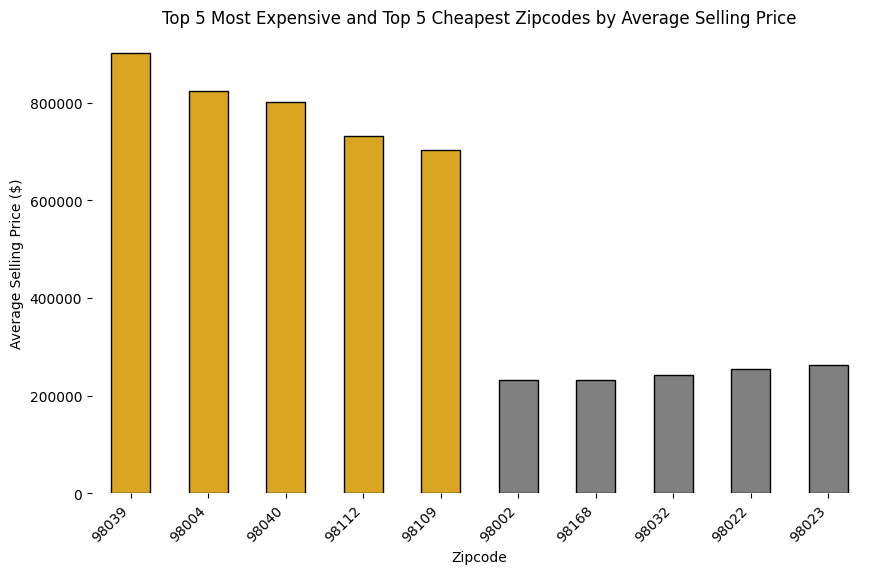

In [79]:


import matplotlib.pyplot as plt


# Calculate the average selling price by zipcode
average_price_by_zipcode = data.groupby('zipcode')['selling_price'].mean()

# Get the top 5 most expensive and top 5 cheapest ZIP codes
top_5_expensive_zipcodes = average_price_by_zipcode.sort_values(ascending=False).head(5)
top_5_cheapest_zipcodes = average_price_by_zipcode.sort_values(ascending=True).head(5)

# Combine the top 5 most expensive and top 5 cheapest into a single DataFrame
top_5_and_bottom_5_zipcodes = pd.concat([top_5_expensive_zipcodes, top_5_cheapest_zipcodes])

# Define the colors
expensive_color = 'goldenrod'
cheap_color = 'grey'

# Plotting the top 5 most expensive and top 5 cheapest ZIP codes without grid and frame
plt.figure(figsize=(10, 6))
ax = top_5_and_bottom_5_zipcodes.plot(kind='bar', 
                                      color=[expensive_color if x in top_5_expensive_zipcodes else cheap_color for x in top_5_and_bottom_5_zipcodes.index], 
                                      edgecolor='black')

# Remove grid and frame
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Top 5 Most Expensive and Top 5 Cheapest Zipcodes by Average Selling Price')
plt.xlabel('Zipcode')
plt.ylabel('Average Selling Price ($)')
plt.xticks(rotation=45, ha='right')
plt.show()

OLD IS MORE EXPENSIVE THAN NEW

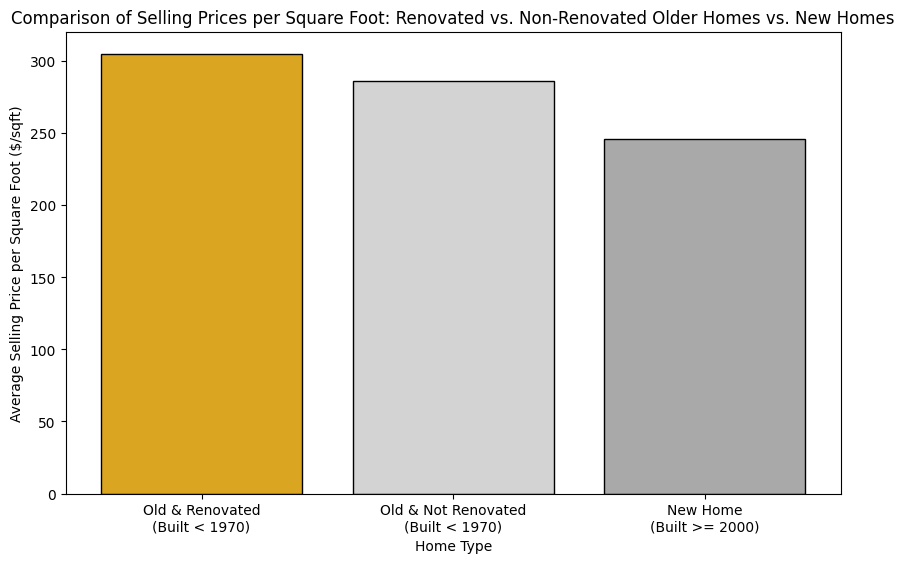

In [81]:
import matplotlib.pyplot as plt

# Calculate the price per square foot
data['price_per_sqft'] = data['selling_price'] / data['sqft_living']

# Calculate the average selling price per square foot for each group
avg_price_per_sqft_old_renovated = data[data['old_and_renovated']]['price_per_sqft'].mean()
avg_price_per_sqft_old_not_renovated = data[data['old_not_renovated']]['price_per_sqft'].mean()
avg_price_per_sqft_new_home = data[data['new_home']]['price_per_sqft'].mean()

# Plotting the comparison with average selling price per square foot
plt.figure(figsize=(10, 6))
plt.bar(['Old & Renovated\n(Built < 1970)', 'Old & Not Renovated\n(Built < 1970)', 'New Home\n(Built >= 2000)'], 
        [avg_price_per_sqft_old_renovated, avg_price_per_sqft_old_not_renovated, avg_price_per_sqft_new_home], 
        color=['goldenrod', 'lightgrey', 'darkgrey'], edgecolor='black')
plt.title('Comparison of Selling Prices per Square Foot: Renovated vs. Non-Renovated Older Homes vs. New Homes')
plt.xlabel('Home Type')
plt.ylabel('Average Selling Price per Square Foot ($/sqft)')
plt.show()

DISTRIBUTION OF HOME GRADES

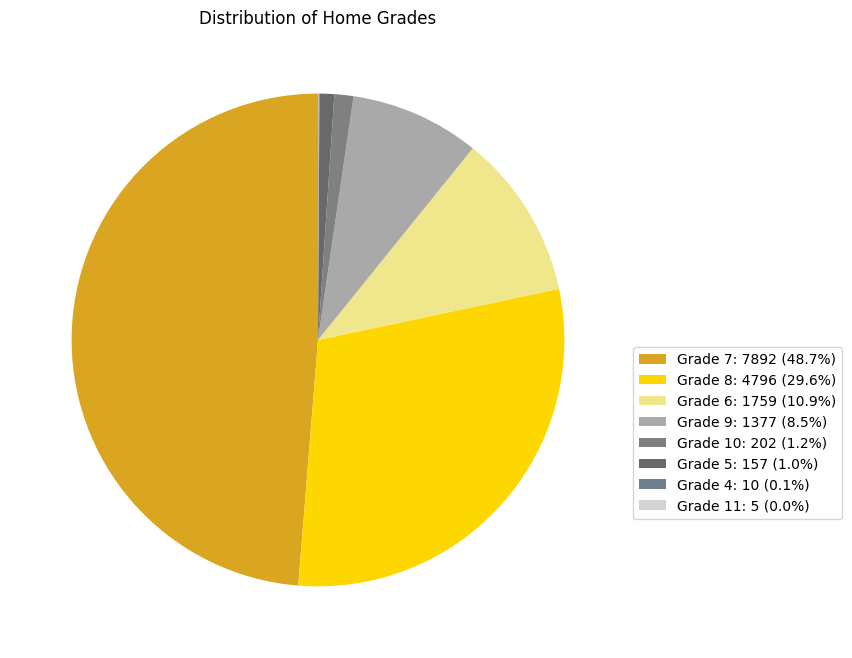

In [84]:

# Calculate the distribution of home grades
grade_distribution = data['grade'].value_counts()

# Update the color mapping to include all possible grades
colors = {
    7: 'goldenrod',
    8: 'gold',
    6: 'khaki',
    9: 'darkgrey',
    10: 'grey',
    11: 'lightgrey',
    5: 'dimgray',
    12: 'silver',
    4: 'slategrey',  
    13: 'gainsboro',  
    3: 'darkslategrey',
    14: 'whitesmoke'
}

# Create a color list for the pie chart based on the grade distribution
color_list = [colors.get(grade, 'black') for grade in grade_distribution.index]

# Plotting the distribution of home grades with custom colors
plt.figure(figsize=(8, 8))
plt.pie(grade_distribution, labels=None, autopct=None, colors=color_list, startangle=90)

# Adding labels outside the pie chart
labels = [f'Grade {grade}: {count} ({count/sum(grade_distribution)*100:.1f}%)' for grade, count in zip(grade_distribution.index, grade_distribution)]
plt.legend(labels, loc="best", bbox_to_anchor=(1, 0.5), fontsize=10)

plt.title('Distribution of Home Grades')
plt.show()

3 RECOMMANDATIONS

In [75]:
# Step 1: Filter the dataset for properties within the middle price range
middle_price_houses = data[(data['selling_price'] >= 300000) & 
                           (data['selling_price'] <= 556825)]

# Step 2: Further filter for houses in central, lively locations (high density, urban ZIP codes)
central_middle_price_houses = middle_price_houses[
    (middle_price_houses['density_ratio'] > middle_price_houses['density_ratio'].median()) &
    (middle_price_houses['zipcode'].isin(urban_zipcodes))
]

# Step 3: Select the top 3 properties based on density ratio for better centrality
top_3_properties = central_middle_price_houses.sort_values(by='density_ratio', ascending=False).head(3)

# Display the top 3 properties
top_3_properties[['house_id', 'selling_price', 'zipcode', 'density_ratio', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms']]

,house_id,selling_price,zipcode,density_ratio,sqft_living,sqft_lot,bedrooms,bathrooms
676,1294300038,450000.0,98116,1.980306,1810.0,914.0,3.0,2.50
12140,7660100238,329950.0,98144,1.577670,1300.0,812.0,3.0,2.50
12806,7904700134,390000.0,98116,1.497268,1370.0,913.0,3.0,3.25
